In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import partial_dependence
from xgboost import XGBRegressor

# Data Preprocessing

In [2]:
# Read the CSV
df = pd.read_csv('C:/Users/User/Downloads/큐슈제강_조업데이터시트_2024년.xlsx - For my use.csv')

# Check and remove rows with missing (NaN) values
missing_count = df.isnull().sum().sum()

if missing_count > 0:
    print(f"Found {missing_count} missing values. Dropping rows with any NaN")
    df = df.dropna()
    print("Missing values removed.")
else:
    print("No missing values found.")

Found 95 missing values. Dropping rows with any NaN
Missing values removed.


In [3]:
# Removes SC410 entries
lower_bound = 9000
upper_bound = 500000000
df = df[df['ID number'].between(lower_bound, upper_bound)]

# Temperature bounds
lower_bound_2 = 1500
upper_bound_2 = 1800
df = df[df['Temperature'].between(lower_bound_2, upper_bound_2)]

# Tap to tap time bounds
if 'Tap to tap time' in df.columns:
    initial_count_time = len(df)
    df = df[df['Tap to tap time'] <= 120]
    removed_count_time = initial_count_time - len(df)
    print(f"Removed {removed_count_time} rows where 'Tap to tap time' > 120.")
else:
    print("Warning: 'Tap to tap time' column not found.")

# Oxygen bounds
if 'Oxygen' in df.columns:
    initial_count_oxygen = len(df)
    df = df[df['Oxygen'] >= 1000]
    removed_count_oxygen = initial_count_oxygen - len(df)
    print(f"Removed {removed_count_oxygen} rows where 'Oxygen' < 1000.")
else:
    print("Warning: 'Tap to tap time' column not found.")

# Power consumption bounds
if 'Power consumption' in df.columns:
    initial_count_power = len(df)
    df = df[df['Power consumption'] <= 400]
    removed_count_power = initial_count_power - len(df)
    print(f"Removed {removed_count_power} rows where 'Power consumption' > 400.")
else:
    print("Warning: 'Power consumption' column not found.")

# Carbon bounds
if 'Carbon' in df.columns:
    initial_count_carbon = len(df)
    df = df[df['Carbon'] >= 200]
    removed_count_carbon = initial_count_carbon - len(df)
    print(f"Removed {removed_count_carbon} rows where 'Carbon' < 200.")
else:
    print("Warning: 'Power consumption' column not found.")

# For double checking
df.to_csv('For_my_use_1.csv', index=False)

Removed 1 rows where 'Tap to tap time' > 120.
Removed 10 rows where 'Oxygen' < 1000.
Removed 14 rows where 'Power consumption' > 400.
Removed 14 rows where 'Carbon' < 200.


In [4]:
# Create datasets
X = df[['Tap to tap time', 'Oxygen', 'Temperature', 'Carbon', 'Gas']]  # include more predictors as needed
y = df['Power consumption']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# MLR

In [5]:
# Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


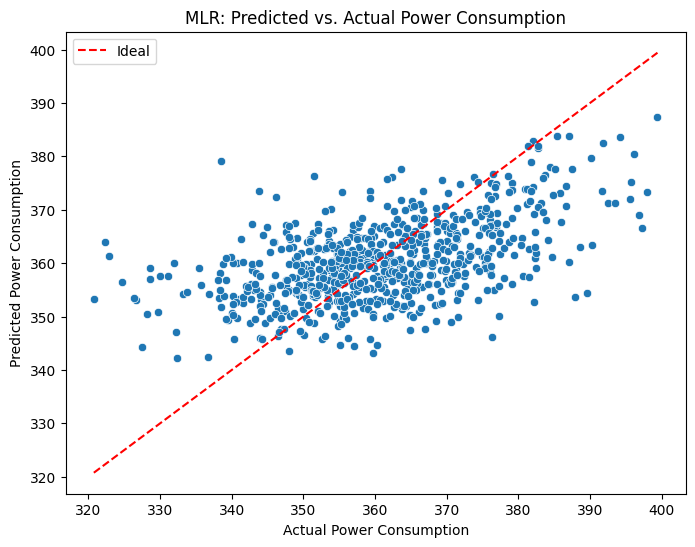


--- Model Evaluation ---
Mean Squared Error: 127.22728640436691
RMSE: 11.279507365322605
R² Score: 0.2779350787212156

Intercept: -94.4102136455844
Coefficients:
  Tap to tap time: 0.797422112488073
  Oxygen: -0.003599417528704428
  Temperature: 0.2533748978771404
  Carbon: 0.06378242835164503
  Gas: -0.31416852225875636


In [6]:
y_pred = model.predict(X_test)

# Actual vs Predicted Power Consumption Plot
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel('Actual Power Consumption')
plt.ylabel('Predicted Power Consumption')
plt.title('MLR: Predicted vs. Actual Power Consumption')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Ideal')
plt.legend()

plt.show()

MSE = mean_squared_error(y_test, y_pred)

# Evaluation metrics
print("\n--- Model Evaluation ---")
print("Mean Squared Error:", MSE)
rmse = np.sqrt(MSE)
print("RMSE:", rmse)
print("R² Score:", r2_score(y_test, y_pred))
print("\nIntercept:", model.intercept_)
print("Coefficients:")
for feature, coef in zip(X.columns, model.coef_):
    print(f"  {feature}: {coef}")

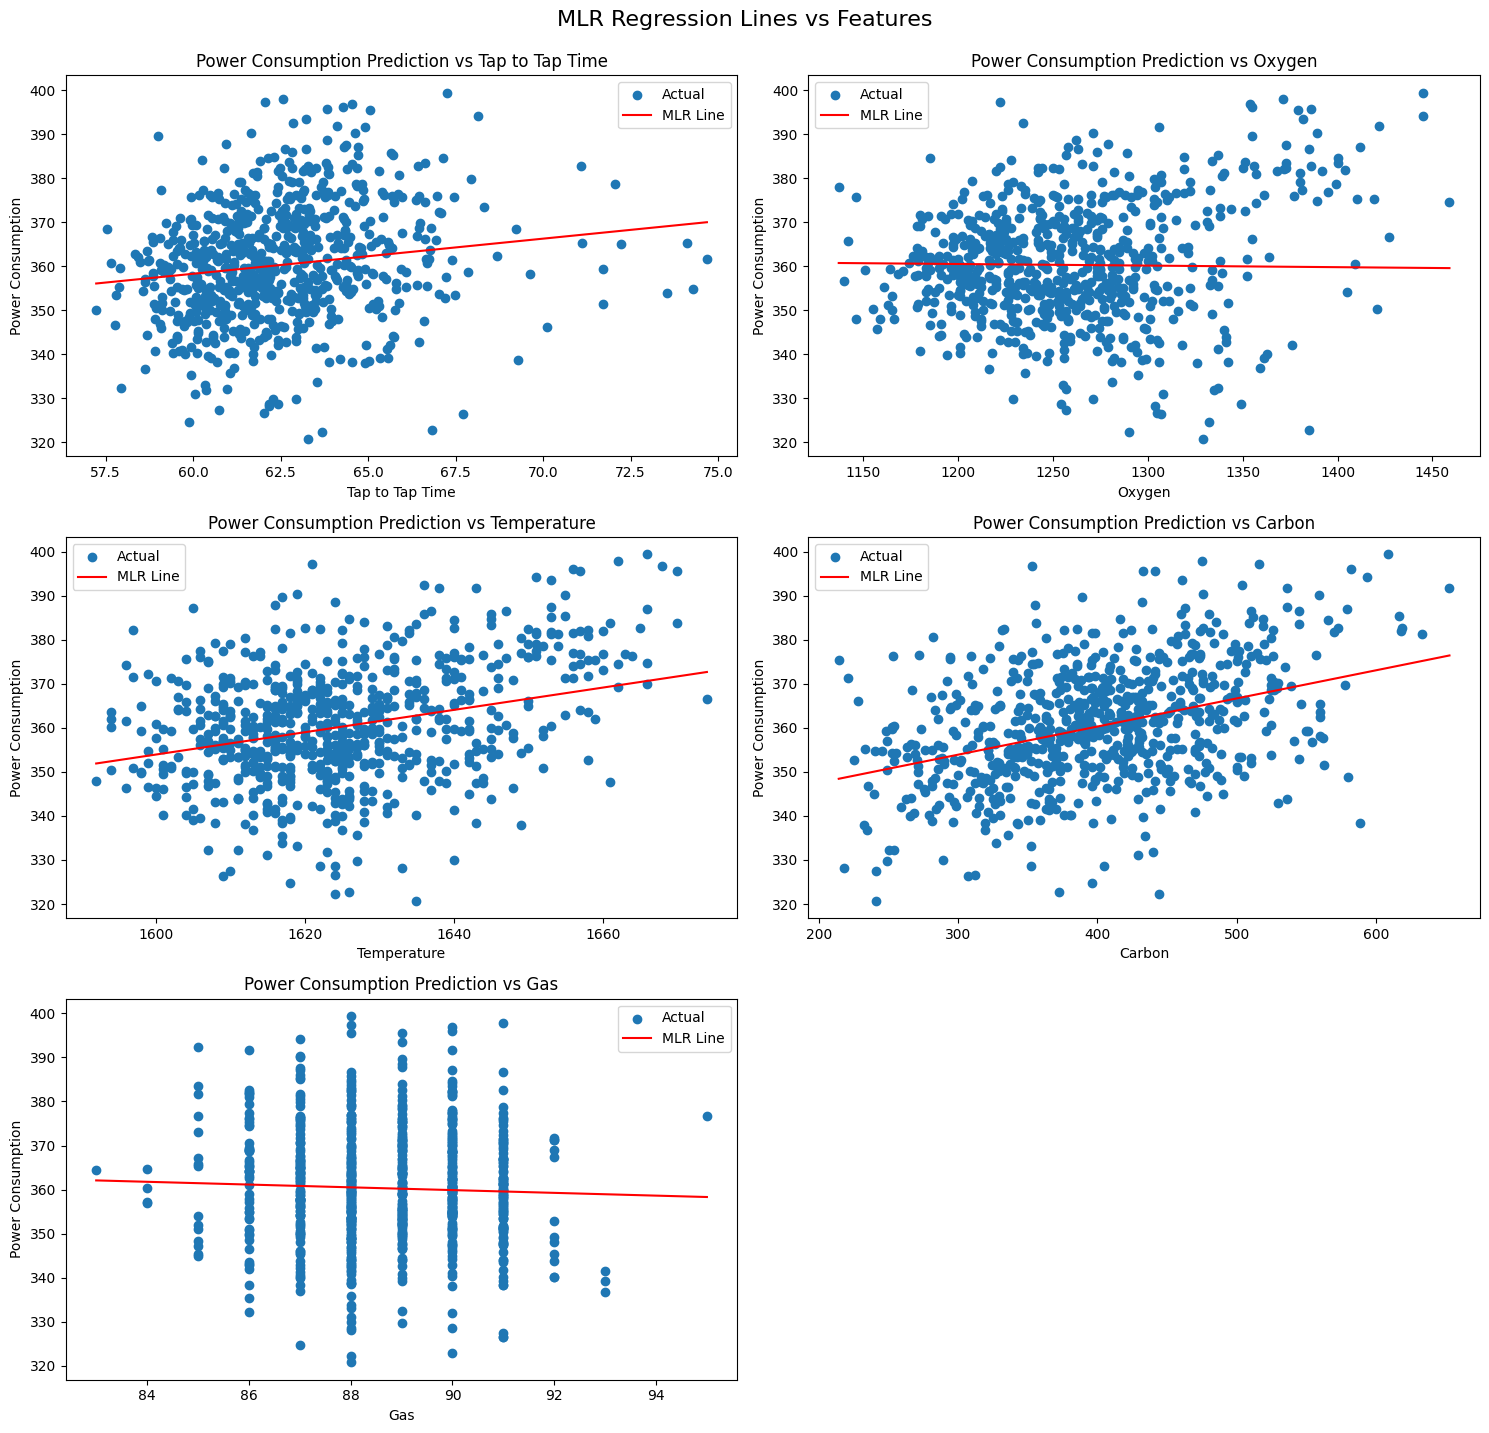

In [7]:
# Get feature means
mean_oxygen = X_test['Oxygen'].mean()
mean_temp = X_test['Temperature'].mean()
mean_carbon = X_test['Carbon'].mean()
mean_tap = X_test['Tap to tap time'].mean()
mean_gas = X_test['Gas'].mean()

# Subplot Grid
fig, axes = plt.subplots(3, 2, figsize=(15, 14))
axes = axes.flatten()

# Plot 1: Power consumption vs Tap to tap time
tap_vals = np.linspace(X_test['Tap to tap time'].min(), X_test['Tap to tap time'].max(), 100)
manual_y_tap = (
    model.intercept_ +
    model.coef_[0] * tap_vals +
    model.coef_[1] * mean_oxygen +
    model.coef_[2] * mean_temp +
    model.coef_[3] * mean_carbon +
    model.coef_[4] * mean_gas
)
axes[0].scatter(X_test['Tap to tap time'], y_test, alpha=1, label='Actual')
axes[0].plot(tap_vals, manual_y_tap, color='red', label='MLR Line')
axes[0].set_xlabel('Tap to Tap Time')
axes[0].set_ylabel('Power Consumption')
axes[0].set_title('Power Consumption Prediction vs Tap to Tap Time')
axes[0].legend()

# Plot 2: Power consumption vs Oxygen
oxygen_vals = np.linspace(X_test['Oxygen'].min(), X_test['Oxygen'].max(), 100)
manual_y_oxygen = (
    model.intercept_ +
    model.coef_[0] * mean_tap +
    model.coef_[1] * oxygen_vals +
    model.coef_[2] * mean_temp +
    model.coef_[3] * mean_carbon +
    model.coef_[4] * mean_gas
)
axes[1].scatter(X_test['Oxygen'], y_test, alpha=1, label='Actual')
axes[1].plot(oxygen_vals, manual_y_oxygen, color='red', label='MLR Line')
axes[1].set_xlabel('Oxygen')
axes[1].set_ylabel('Power Consumption')
axes[1].set_title('Power Consumption Prediction vs Oxygen')
axes[1].legend()

# Plot 3: Power consumption vs Temperature
temp_vals = np.linspace(X_test['Temperature'].min(), X_test['Temperature'].max(), 100)
manual_y_temp = (
    model.intercept_ +
    model.coef_[0] * mean_tap +
    model.coef_[1] * mean_oxygen +
    model.coef_[2] * temp_vals +
    model.coef_[3] * mean_carbon +
    model.coef_[4] * mean_gas
)
axes[2].scatter(X_test['Temperature'], y_test, alpha=1, label='Actual')
axes[2].plot(temp_vals, manual_y_temp, color='red', label='MLR Line')
axes[2].set_xlabel('Temperature')
axes[2].set_ylabel('Power Consumption')
axes[2].set_title('Power Consumption Prediction vs Temperature')
axes[2].legend()

# Plot 4: Power consumption vs Carbon
carbon_vals = np.linspace(X_test['Carbon'].min(), X_test['Carbon'].max(), 100)
manual_y_carbon = (
    model.intercept_ +
    model.coef_[0] * mean_tap +
    model.coef_[1] * mean_oxygen +
    model.coef_[2] * mean_temp +
    model.coef_[3] * carbon_vals +
    model.coef_[4] * mean_gas
)
axes[3].scatter(X_test['Carbon'], y_test, alpha=1, label='Actual')
axes[3].plot(carbon_vals, manual_y_carbon, color='red', label='MLR Line')
axes[3].set_xlabel('Carbon')
axes[3].set_ylabel('Power Consumption')
axes[3].set_title('Power Consumption Prediction vs Carbon')
axes[3].legend()

# Plot 5: Power consumption vs Gas
gas_vals = np.linspace(X_test['Gas'].min(), X_test['Gas'].max(), 100)
manual_y_gas = (
    model.intercept_ +
    model.coef_[0] * mean_tap +
    model.coef_[1] * mean_oxygen +
    model.coef_[2] * mean_temp +
    model.coef_[3] * mean_carbon +
    model.coef_[4] * gas_vals
)
axes[4].scatter(X_test['Gas'], y_test, alpha=1, label='Actual')
axes[4].plot(gas_vals, manual_y_gas, color='red', label='MLR Line')
axes[4].set_xlabel('Gas')
axes[4].set_ylabel('Power Consumption')
axes[4].set_title('Power Consumption Prediction vs Gas')
axes[4].legend()

# Remove unused sixth subplot
fig.delaxes(axes[5])

# Final formatting
plt.tight_layout()
plt.suptitle('MLR Regression Lines vs Features', fontsize=16, y=1.02)
plt.show()

# XGBoost

In [8]:
# XGBoost Model set up
xgb_model = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000,
    learning_rate=0.005,
    max_depth= 4,
    random_state=42
)

xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)

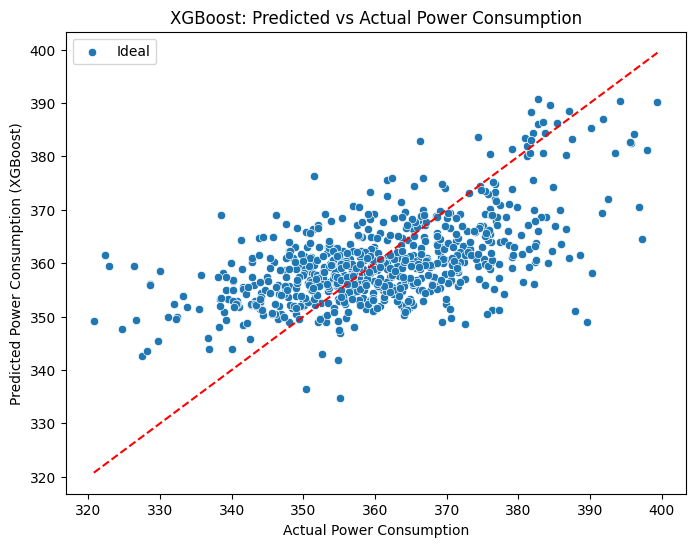


--- XGBoost Model Evaluation ---
Mean Squared Error: 115.86391989730556
XGBoost RMSE: 10.764010400278586
R² Score: 0.342426655758432


In [9]:
# XGBoost Actual vs Predicted Power Consumption Plot
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=xgb_pred)
plt.xlabel('Actual Power Consumption')
plt.ylabel('Predicted Power Consumption (XGBoost)')
plt.title('XGBoost: Predicted vs Actual Power Consumption')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.legend(['Ideal'])
plt.show()

# Evaluation
print("\n--- XGBoost Model Evaluation ---")
print("Mean Squared Error:", mean_squared_error(y_test, xgb_pred))
rmse_xgb = np.sqrt(mean_squared_error(y_test, xgb_pred))
print("XGBoost RMSE:", rmse_xgb)
print("R² Score:", r2_score(y_test, xgb_pred))

C:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\inspection\_partial_dependence.py:717: FutureWarning: The column 3 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(
C:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\inspection\_partial_dependence.py:717: FutureWarning: The column 4 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(


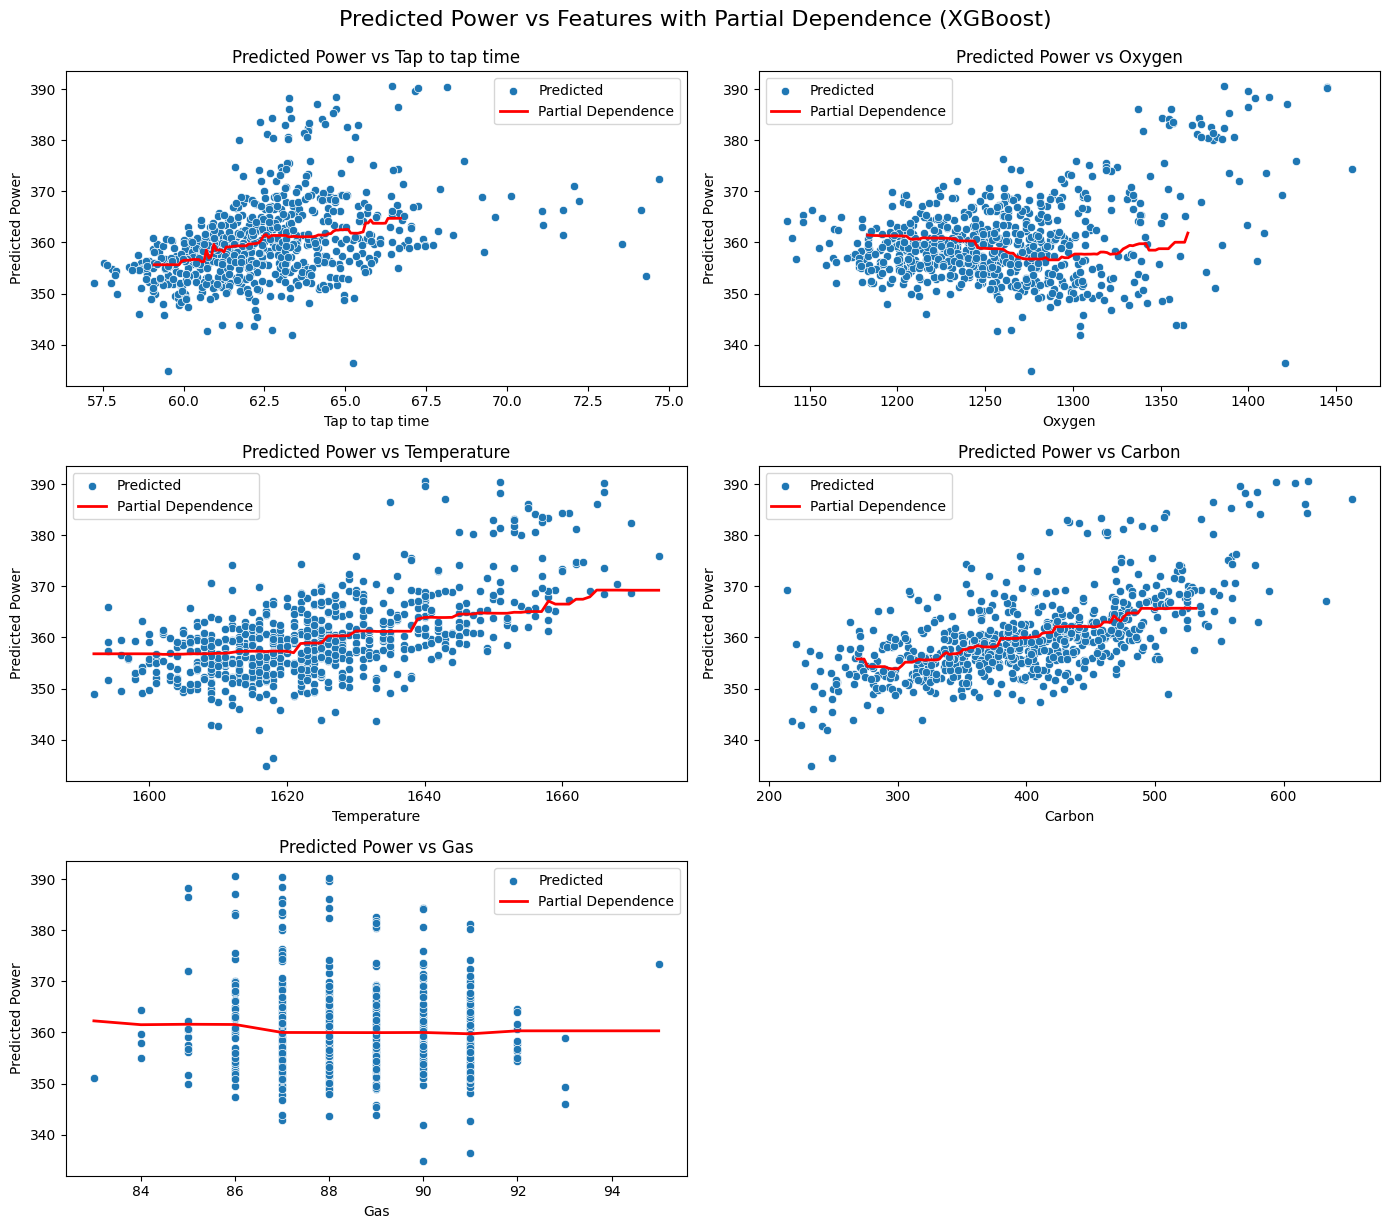

In [10]:
# Features to plot
features = ['Tap to tap time', 'Oxygen', 'Temperature', 'Carbon', 'Gas']
n_features = len(features)

# Subplot Grid
rows, cols = 3, 2
fig, axes = plt.subplots(rows, cols, figsize=(14, 12))
axes = axes.flatten()  # To index easily

# Plot the features
for i, feature in enumerate(features):
    ax = axes[i]
    feature_index = X_test.columns.get_loc(feature)

    # Partial dependence
    pd_result = partial_dependence(xgb_model, X_test, [feature_index], kind='average')
    x_vals = pd_result['grid_values'][0]
    y_vals = pd_result['average'][0]

    # Scatter: actual model predictions
    sns.scatterplot(
        x=X_test[feature],
        y=xgb_model.predict(X_test),
        alpha=1,
        ax=ax,
        label='Predicted'
    )

    # Partial dependence line
    ax.plot(x_vals, y_vals, color='red', linewidth=2, label='Partial Dependence')

    # Format
    ax.set_xlabel(feature)
    ax.set_ylabel('Predicted Power')
    ax.set_title(f'Predicted Power vs {feature}')
    ax.legend()

# Remove any unused subplot
if len(axes) > n_features:
    for j in range(n_features, len(axes)):
        fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle('Predicted Power vs Features with Partial Dependence (XGBoost)', fontsize=16, y=1.02)
plt.show()

# Time Series Data

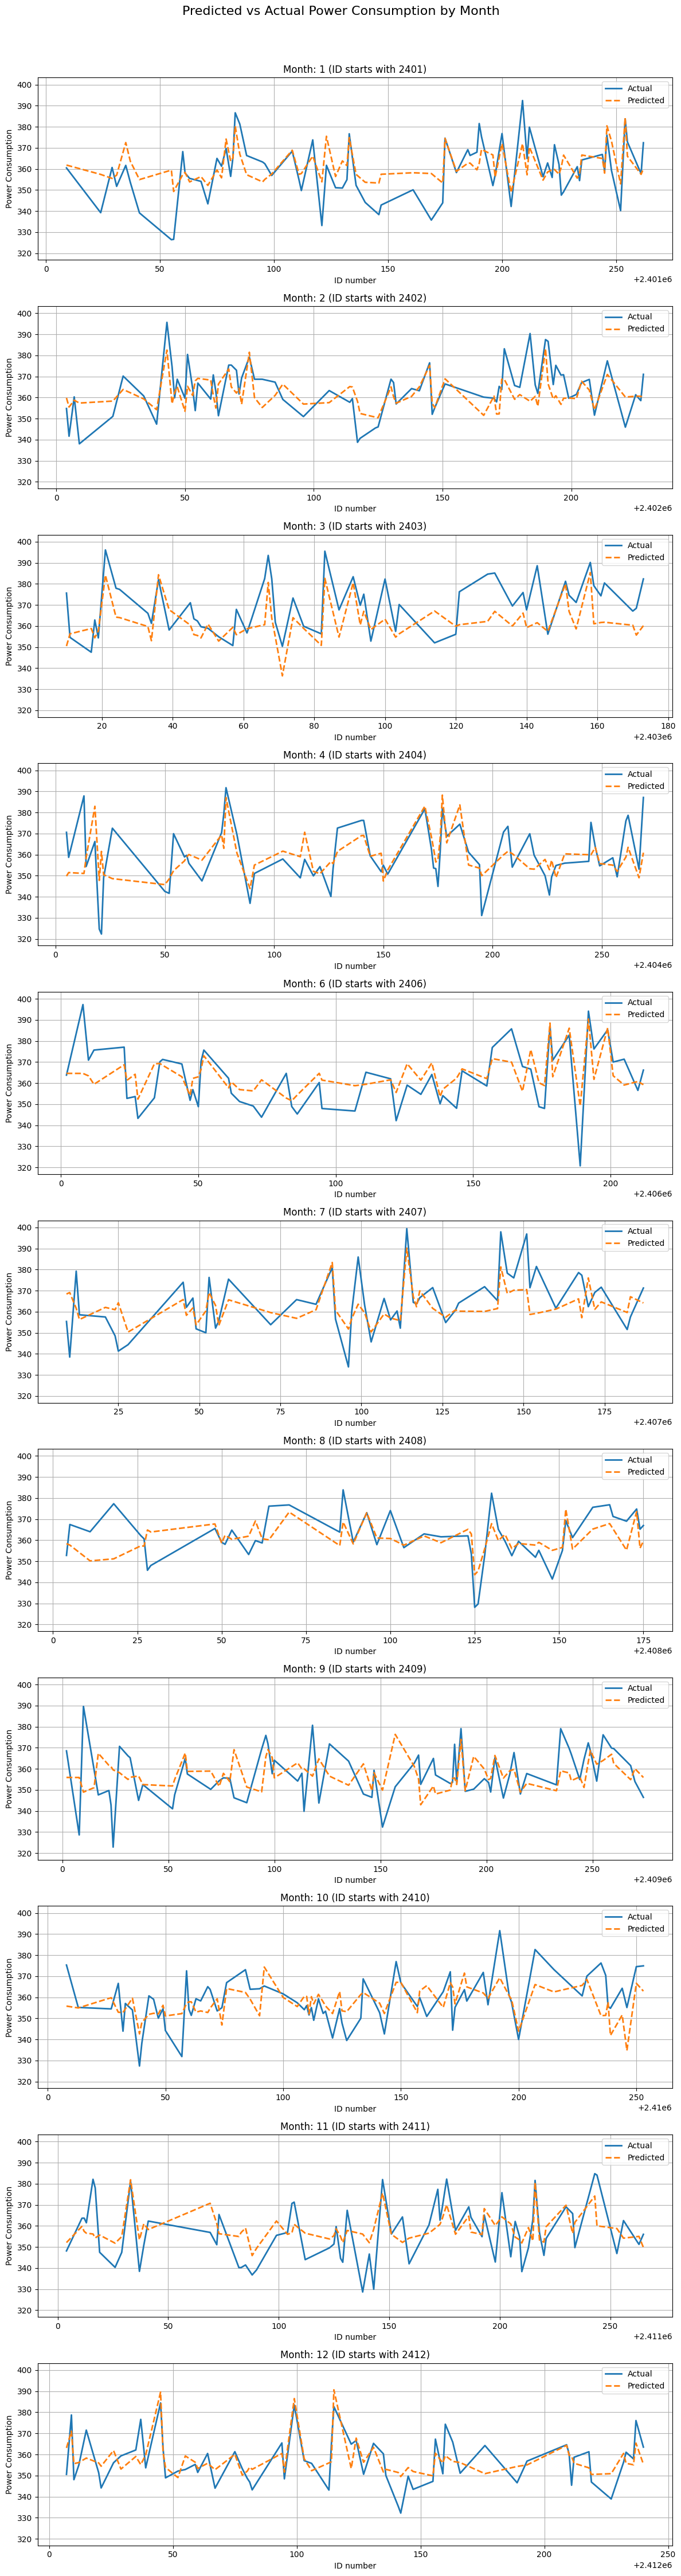

In [11]:
# Combine ID number, Actual power, and Predicted power into one DataFrame
id_aligned_df = df[['ID number']].loc[X_test.index].copy()
id_aligned_df['Actual Power'] = y_test.values
id_aligned_df['Predicted Power'] = xgb_pred  # or xgb_pred for XGBoost

# Sort by ID number for line plotting
id_aligned_df = id_aligned_df.sort_values('ID number').reset_index(drop=True)

# Extract month from ID (e.g., 2401xxx → 1)
id_aligned_df['Month'] = id_aligned_df['ID number'].astype(str).str[2:4].astype(int)

# Prepare list of months to display (exclude missing ones like May if needed)
months = sorted(id_aligned_df['Month'].unique())

# Set up subplots
n_months = len(months)
fig, axes = plt.subplots(n_months, 1, figsize=(12, 4 * n_months), sharey=True)

if n_months == 1:
    axes = [axes]  # Ensure axes is iterable

for i, month in enumerate(months):
    ax = axes[i]
    month_df = id_aligned_df[id_aligned_df['Month'] == month].sort_values('ID number')

    ax.plot(month_df['ID number'], month_df['Actual Power'], label='Actual', linewidth=2)
    ax.plot(month_df['ID number'], month_df['Predicted Power'], label='Predicted', linestyle='--', linewidth=2)
    ax.set_title(f'Month: {month} (ID starts with 24{month:02d})')
    ax.set_xlabel('ID number')
    ax.set_ylabel('Power Consumption')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.suptitle('Predicted vs Actual Power Consumption by Month', fontsize=16, y=1.02)
plt.show()


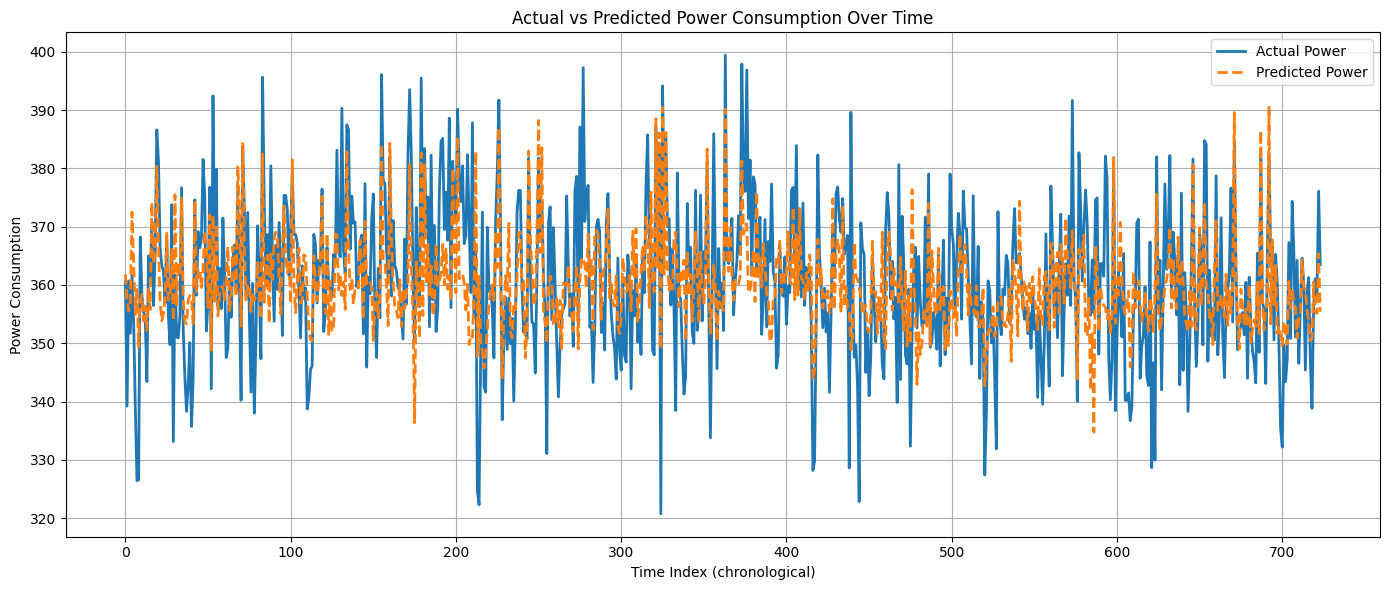

In [12]:
# Create a continuous time index
id_aligned_df['Time Index'] = range(len(id_aligned_df))

# Plot with continuous index
plt.figure(figsize=(14, 6))
plt.plot(id_aligned_df['Time Index'], id_aligned_df['Actual Power'], label='Actual Power', linewidth=2)
plt.plot(id_aligned_df['Time Index'], id_aligned_df['Predicted Power'], label='Predicted Power', linestyle='--', linewidth=2)
plt.xlabel('Time Index (chronological)')
plt.ylabel('Power Consumption')
plt.title('Actual vs Predicted Power Consumption Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()